# Mean Force Integration in 1D

Import HILLS and COLVAR files, compute the mean force and integrate using the pyMFI (would be) module. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
if 'path' in locals():
    os.chdir(path)
    print(path)
else: 
    os.chdir("../")
    path = os.getcwd()
    print(path)
from pyMFI import MFI1D
from pyMFI import run_plumed
os.chdir(path + "/DATA_examples/1D_double_well")

/home/ucecabj/Desktop/pyMFI_git


20.0 %   OFE = 12.8687
40.0 %   OFE = 12.9747
60.0 %   OFE = 13.0088
80.0 %   OFE = 13.0717
100.0 %   OFE = 13.0942


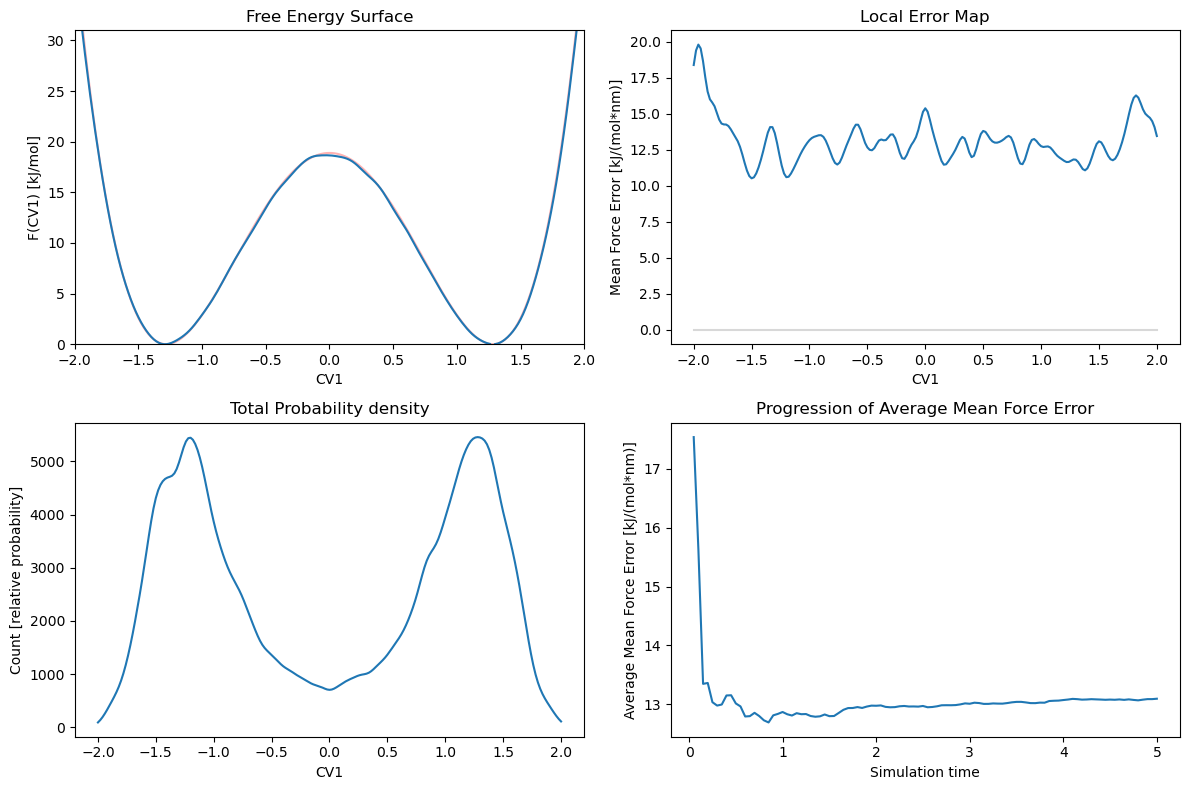

In [4]:
# # Run simulation
# run_plumed.run_langevin1D(simulation_steps = 1_000_000, gaus_width=0.1, gaus_height=1, biasfactor=10)

#Read the HILLS file
HILLS=MFI1D.load_HILLS(hills_name="HILLS")

#Read the Colvar File
position = MFI1D.load_position(position_name="position")

#Compute the time-independent mean force
results = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.05, kT = 1, log_pace = 5, error_pace = 100, min_grid=-2.0, max_grid=2.0)
X, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, \
    error_history_collection, volume_history, intermediate_fes_collection, intermediate_cutoff_collection, intermediate_time_collection = results


# Plot Recap
MFI1D.plot_recap(X, MFI1D.zero_to_nan(FES), MFI1D.zero_to_nan(Ftot_den), MFI1D.zero_to_nan(ofe), error_history_collection[:,1], error_history_collection[:,2], FES_lim=31, ofe_lim = 15, error_log_scale=0); plt.show()
# plt.plot(error_history_collection[:,2], error_history_collection[:,1]); plt.show()


# #Compute the time-independent mean force with intermediate results
# X, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_history_collection, volume_history, intermediate_fes_collection, intermediate_cutoff_collection, intermediate_time_collection = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.1, kT = 1, log_pace = 5, error_pace = 100, min_grid=-2.0, max_grid=2.0, WellTempered=1, FES_cutoff=30, intermediate_fes_number=100)
# MFI1D.plot_recap(X, MFI1D.zero_to_nan(FES), MFI1D.zero_to_nan(Ftot_den), MFI1D.zero_to_nan(ofe), error_history_collection[:,1], error_history_collection[:,2], FES_lim=31, ofe_lim = 15, error_log_scale=0); plt.show()
# plt.plot(X, intermediate_fes_collection[5]); plt.show()

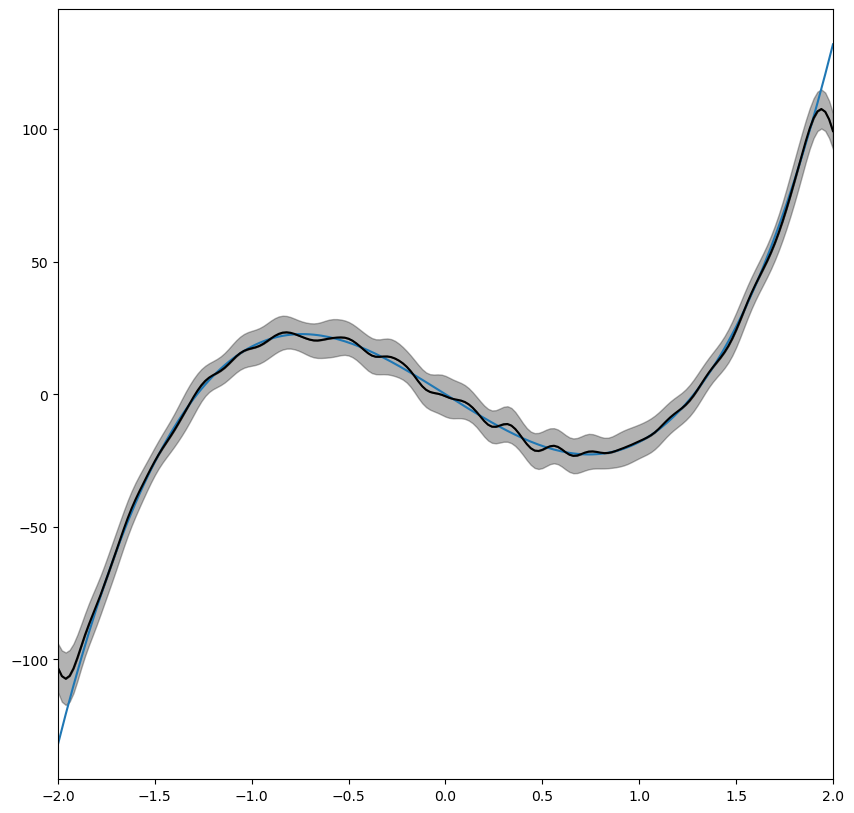

In [5]:
# plt.plot(X, Ftot)

F = 7*X**4-23*X**2
F = F - min(F)
Ff = 28*X**3 - 46*X

plt.figure(figsize=(10,10))
plt.plot(X,Ff)
plt.plot(X, MFI1D.zero_to_nan(Ftot*cutoff), color="black")
plt.fill_between(X, MFI1D.zero_to_nan(Ftot*cutoff), Ftot-MFI1D.zero_to_nan(ofe*cutoff)/2, color="black", alpha=0.3)
plt.fill_between(X, MFI1D.zero_to_nan(Ftot*cutoff), Ftot+MFI1D.zero_to_nan(ofe*cutoff)/2, color="black", alpha=0.3)
plt.xlim(-2,2)
plt.show()

In [3]:
# results_path = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/results_plot"

# MFI1D.save_pkl([X, F, Ff,  MFI1D.zero_to_nan(FES*cutoff), MFI1D.zero_to_nan(Ftot*cutoff), MFI1D.zero_to_nan(ofe*cutoff), ofe_history, time_history], results_path + "/MFI1D_results.pkl")


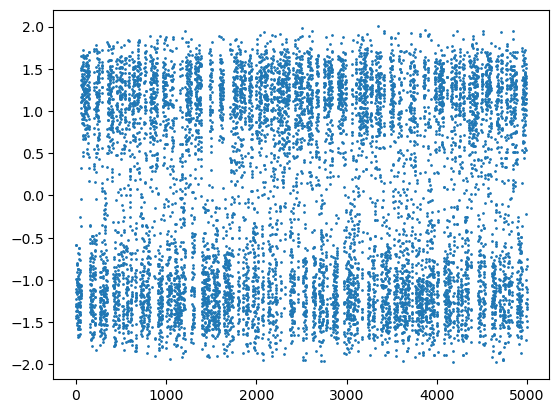

In [6]:
plt.scatter(HILLS[:,0],HILLS[:,1], s=1)